In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [2]:
#Specify the stock that you are tracking.
stock_ticker = ['AAPL'] 

# Reading the data for the specified stock from yahoo finance from 1st Jan 2000
df = web.DataReader('AAPL', data_source='yahoo', start='2000-01-01')
df.head(2)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,4.017857,3.631696,3.745536,3.997768,133949200.0,3.470226
2000-01-04,3.950893,3.613839,3.866071,3.660714,128094400.0,3.177650


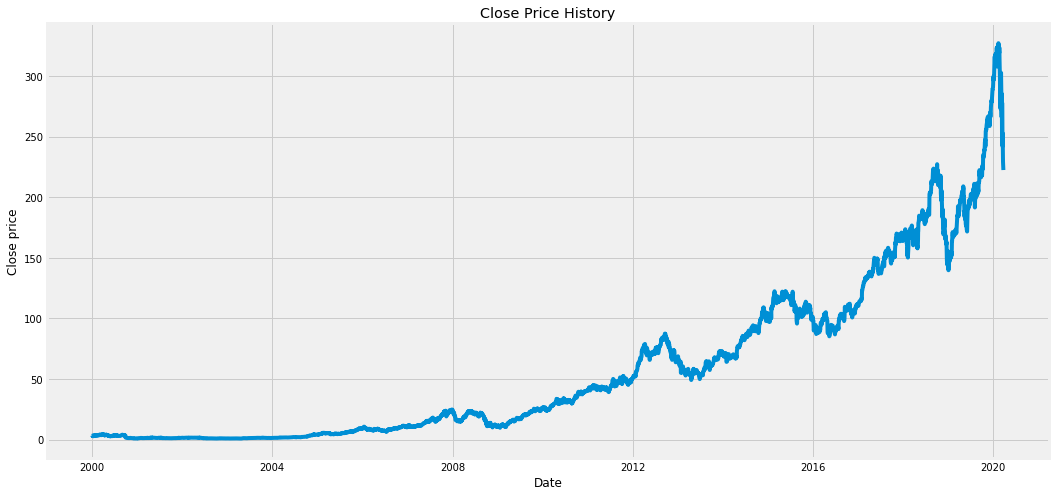

In [3]:
# Adjusted Close is plotted.
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Close price')
plt.show()

In [4]:
df.shape

(5087, 6)

In [5]:
# Converting the column to np.array
data = df.filter(['Adj Close'])
dataset = data.values

# Out of the total rows, 80% is considered for training
train_data_len = math.ceil(len(dataset)*0.8)
train_data_len

4070

In [6]:
# Using min max scaler to scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00813988],
       [0.00724347],
       [0.00738595],
       ...,
       [0.74747729],
       [0.69986505],
       [0.67914085]])

In [7]:
# Defining training set (including X and y) as the data till the first 80% of the entired scaled dataset.
train_data = scaled_data[0:train_data_len,:]

# Defining x_train and y_train.
# For the first 60 timestamp values (x_train), 61st value is the prediction (y_train)
# We define lists
# x_train = list of arrays of all the x values (1-60, 2-61, 3-62 etc.)
# y_train = list of values which are the predictions for data for example(for x_train array of 1-60, the prediction will be the 61st value.)
x_train = []
y_train = []
steps = 60

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=61:
        print(x_train)
        print(y_train)
        print()

[array([0.00813988, 0.00724347, 0.00738595, 0.00653109, 0.00695852,
       0.0067923 , 0.00631738, 0.00578903, 0.00669731, 0.00704756,
       0.00738001, 0.00762934, 0.00828829, 0.00808051, 0.00759966,
       0.00816956, 0.00797366, 0.00795585, 0.00716036, 0.0073622 ,
       0.00702976, 0.00689322, 0.00732065, 0.00776588, 0.00834172,
       0.0084189 , 0.00820518, 0.00828829, 0.00783712, 0.00850794,
       0.00881071, 0.00834766, 0.0084189 , 0.00807458, 0.00831797,
       0.0085495 , 0.00845006, 0.00799147, 0.00826455, 0.00839515,
       0.00988521, 0.00909566, 0.00966556, 0.00944591, 0.00917876,
       0.00909566, 0.0091194 , 0.00945184, 0.00903036, 0.00835953,
       0.0085495 , 0.0090541 , 0.00938061, 0.00919064, 0.01032451,
       0.01120311, 0.01093003, 0.0106807 , 0.01076381, 0.01072226])]
[0.010419494711240908]

[array([0.00813988, 0.00724347, 0.00738595, 0.00653109, 0.00695852,
       0.0067923 , 0.00631738, 0.00578903, 0.00669731, 0.00704756,
       0.00738001, 0.00762934, 0.0

In [8]:
# Converting the lists into np.array
x_train, y_train = np.array(x_train), np.array(y_train)

In [9]:
x_train.shape

(4010, 60)

In [10]:
# Reshape the data to 3D
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(4010, 60, 1)

In [11]:
# Defining two LSTM layers and 2 Dense layers)
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
4010/4010 [==============================] - 113s 28ms/step - loss: 1.5379e-04


In [13]:
# Defining x and y of test data
test_data = scaled_data[train_data_len-60:,:]
x_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [14]:
# Converting x_test list of arrays into an np.array
x_test = np.array(x_test)
x_test.shape

(1017, 60)

In [15]:
# Reshaping into a 3D array
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
x_test.shape

(1017, 60, 1)

In [16]:
# Obtaining predictions from the model for the x_test
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# mean absolute error
mae = mean_absolute_error(predictions, y_test)
nmae = mae/np.mean(y_test)*100

# root mean squared error
mse = mean_squared_error(predictions, y_test)
rmse = np.sqrt(mse)
nrmse = rmse/np.mean(y_test)*100

print("Normalised MAE : {} %".format(round(nmae,2)))
print("Normalised RMSE : {} %".format(round(nrmse,2)))

Normalised MAE : 2.88 %
Normalised RMSE : 4.11 %


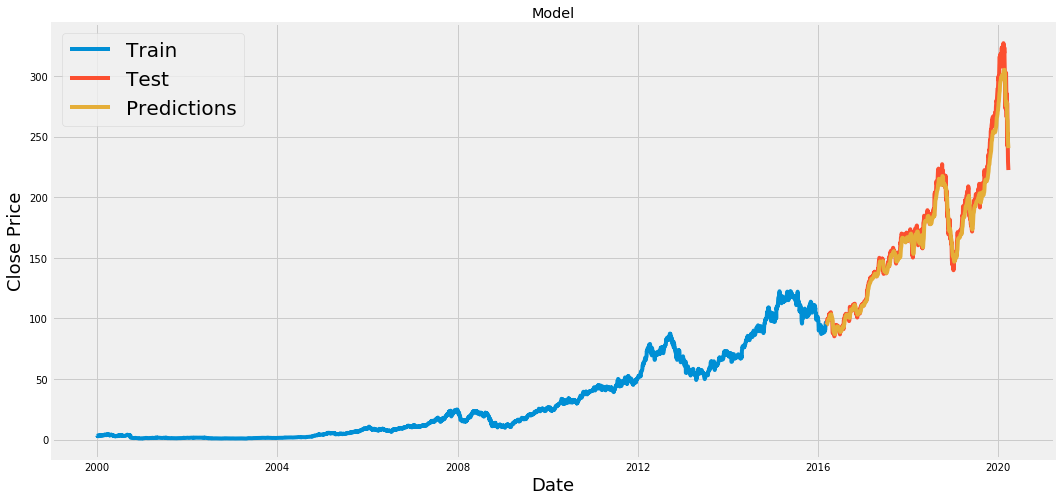

In [18]:
# Plotting the timeseries

train = data[:train_data_len]
valid = data[train_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close','Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], fontsize=20)
plt.show()